# Using Creators abd Degraders to Generate Galaxy Samples with Errors and Biases

This notebook demonstrates how to use a RAIL Creator to create galaxy samples, and how to use Degraders to add various errors and biases to the sample.

Note that in the parlance of the Creation Module, "degradation" is any post-processing that occurs to the "true" sample generated by the Creator's Engine. This can include adding photometric errors, applying quality cuts, introducing systematic biases, etc.

In this notebook, we will first learn how to draw samples from a RAIL Creator object.
Then we will demonstrate how to use the following RAIL Degraders:
1. [**LSSTErrorModel**](#LSSTErrorModel), which adds photometric errors
2. [**BandCut**](#BandCut), which applies cuts to the specified columns of the sample
3. [**InvRedshiftIncompleteness**](#InvRedshiftIncompleteness), which introduces sample incompleteness
4. [**LineConfusion**](#LineConfusion), which introduces spectroscopic errors

Throughout the notebook, we will show how you can chain all these Degraders together to build a more complicated degrader.
Hopefully, this will allow you to see how you can build your own degrader.

*Note on generating redshift posteriors*: regardless of what Degraders you apply, when you use a Creator to estimate posteriors, the posteriors will *always* be calculated with respect to the "true" distribution. This is the whole point of the Creation Module -- you can generate degraded samples for which we still have access to the *true* posteriors. For an example of how to calculate posteriors, see `posterior-demo.ipynb`.

In [1]:
from pzflow.examples import get_example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness, LineConfusion, BandCut
import matplotlib.pyplot as plt

Found classifier FZBoost
Found classifier randomPZ
Found classifier simpleNN
Found classifier trainZ
Found classifier BPZ_lite


## "True" Creator

First, let's make a Creator that has no degradation. We can use it to generate a "true" sample, to which we can compare all the degraded samples below.

Note: When instantiating a Creator, you must supply an "engine". This can be any object with `sample` and `get_posterior` methods. In this example, we will use a normalizing flow from the [pzflow](https://github.com/jfcrenshaw/pzflow) package. However, everything in this notebook is totally agnostic to what the underlying engine is.

In [2]:
flowEngine = engines.FlowEngine(get_example_flow())
creator_truth = Creator(flowEngine)

In [3]:
nsamples = int(1e5)
samples_truth = creator_truth.sample(nsamples, seed=0)
samples_truth

,redshift,u,g,r,i,z,y
0,1.226985,27.083509,26.304155,25.616962,24.874014,23.937748,23.449104
1,0.452907,27.262863,26.878557,26.185724,26.009174,25.947435,25.715988
2,1.706597,29.984833,28.296618,27.614500,26.768204,25.935947,25.483606
3,0.624633,25.065351,24.597799,23.901598,23.375942,23.225800,23.087355
4,1.670389,27.000587,26.240963,25.612917,24.929920,24.566616,24.310099
...,...,...,...,...,...,...,...
99995,0.876008,25.017206,24.733490,24.255152,23.577719,23.242092,23.120602
99996,0.492211,28.189255,27.254532,26.205481,25.767265,25.555597,25.346964
99997,0.492648,29.344812,27.734581,26.317329,25.633520,25.319094,25.086283
99998,0.539202,22.549107,21.783680,20.752436,20.252380,20.079081,19.904387


<a id="LSSTErrorModel"></a>
## Degrader 1: LSSTErrorModel

Now, we will demonstrate the `LSSTErrorModel`, which adds photometric errors using the model from [Ivezic et al. 2019](https://arxiv.org/abs/0805.2366). 

Let's create an error model with the default settings
(with one exception: the Flow we are using inside these Creators produces photometry with the names "u", "g", "r", etc. instead of "lsst_u", "lsst_g", "lsst_r", etc. Therefore, I pass a bandNames dictionary that translates between these two naming schemes)

In [4]:
errorModel = LSSTErrorModel(bandNames={f"lsst_{b}": b for b in "ugrizy"})

To see the details of the model, including the default settings we are using, you can just print the model:

In [5]:
errorModel

LSSTErrorModel parameters:

Model for bands: u, g, r, i, z, y

Exposure time = 30.0 s
Number of years of observations = 10.0
Mean visits per year per band:
   u: 5.6, g: 8.0, r: 18.4, i: 18.4, z: 16.0, y: 16.0
Airmass = 1.2
Irreducible system error = 0.005
Extended source model: add 0.0mag to 5-sigma depth for point sources
Magnitudes dimmer than 30.0 are set to nan
gamma for each band:
   u: 0.038, g: 0.039, r: 0.039, i: 0.039, z: 0.039, y: 0.039

The following 5-sigma limiting mags are calculated using the parameters that follow them:
   u: 23.83, g: 24.90, r: 24.47, i: 24.03, z: 23.46, y: 22.53
Cm for each band:
   u: 23.09, g: 24.42, r: 24.44, i: 24.32, z: 24.16, y: 23.73
Median zenith sky brightness in each band:
   u: 22.99, g: 22.26, r: 21.2, i: 20.48, z: 19.6, y: 18.61
Median zenith seeing FWHM (in arcseconds) for each band:
   u: 0.81, g: 0.77, r: 0.73, i: 0.71, z: 0.69, y: 0.68
Extinction coefficient for each band:
   u: 0.491, g: 0.213, r: 0.126, i: 0.096, z: 0.069, y: 0.17

Now let's add this error model as a degrader and draw some samples with photometric errors.

In [6]:
creator_w_errs = Creator(flowEngine, errorModel)
samples_w_errs = creator_w_errs.sample(nsamples, seed=0)
samples_w_errs

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,1.226985,26.717048,0.373354,26.265255,0.077804,25.574134,0.040773,24.891589,0.032898,23.959695,0.025392,23.414904,0.035743
1,0.452907,28.474639,1.881396,26.898989,0.139053,26.187058,0.071198,25.986950,0.088990,25.854752,0.141752,25.738005,0.299251
2,1.706597,99.000000,99.000000,28.397567,0.551680,27.860965,0.331214,26.867904,0.199833,25.886772,0.145983,25.180514,0.179202
3,0.624633,25.053104,0.081320,24.603959,0.017749,23.907207,0.010174,23.361737,0.009506,23.198366,0.013414,23.056295,0.025978
4,1.670389,26.521035,0.311809,26.240630,0.076073,25.623222,0.042623,24.943344,0.034459,24.584178,0.044377,24.141331,0.069090
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.876008,24.977813,0.075939,24.727322,0.019691,24.247633,0.013052,23.575706,0.011008,23.239161,0.013850,23.106700,0.027159
99996,0.492211,28.132166,1.372622,27.531274,0.248606,26.134776,0.067876,25.716394,0.069473,25.359766,0.090009,25.578996,0.258523
99997,0.492648,27.557260,0.808621,28.424078,0.565309,26.394756,0.086101,25.726031,0.070088,25.490553,0.101473,25.020678,0.154719
99998,0.539202,22.547423,0.010004,21.786537,0.005222,20.750751,0.005040,20.259399,0.005037,20.070498,0.005074,19.908150,0.005244


Notice some of the magnitudes are NaN's. These are non-detections. This means those observed magnitudes were beyond the 30mag limit that is default in `LSSTErrorModel`. You can change this limit (or the flag that marks non-detections) when you instantiate the error model.

Let's plot the error as a function of magnitude

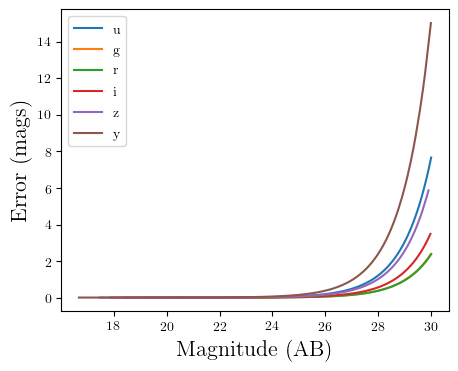

In [7]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

for band in "ugrizy":
    
    # pull out the magnitudes and errors
    mags = samples_w_errs[band].to_numpy()
    errs = samples_w_errs[band+"_err"].to_numpy()
    
    # sort them by magnitude
    mags, errs = mags[mags.argsort()], errs[mags.argsort()]
    
    # plot errs vs mags
    ax.plot(mags, errs, label=band)  
    
ax.legend()
ax.set(xlabel="Magnitude (AB)", ylabel="Error (mags)")
plt.show()

You can see that the photometric error increases as magnitude gets dimmer, just like you would expect. Notice, however, that we have galaxies as dim as magnitude 30. This is because the Flow produces a sample much deeper than the LSST 5-sigma limiting magnitudes. There are no galaxies dimmer than magnitude 30 because LSSTErrorModel sets magnitudes > 30 equal to 99 (the flag for non-detection). You can change this by setting `magLim=...` in the constructor for `LSSTErrorModel`. 

<a id="BandCut"></a>
## Degrader 2: BandCut

Recall how the sample above has galaxies as dim as magnitude 30. This is well beyond the LSST 5-sigma limiting magnitudes, so it will be useful to apply cuts to the data to filter out these super-dim samples. We can apply these cuts using the `BandCut` degrader (note that despite its name, you can use `BandCut` to apply cuts to any column in the sample, including redshift).

Let's create a Degrader that first adds photometric errors, then cuts at i<25.3, which is the LSST gold sample.

In [8]:
def goldCutWithErrs(data, seed=None):
    # apply the error model from before
    data = errorModel(data, seed)
    # now make a cut on observed i band
    data = BandCut({"i": 25.3})(data, seed)
    return data

Now we can stick this into a Creator and draw a new sample

In [9]:
creator_gold_w_errs = Creator(flowEngine, degrader=goldCutWithErrs)
samples_gold_w_errs = creator_gold_w_errs.sample(nsamples, seed=0)
samples_gold_w_errs

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,1.226985,26.717048,0.373354,26.265255,0.077804,25.574134,0.040773,24.891589,0.032898,23.959695,0.025392,23.414904,0.035743
1,0.624633,25.053104,0.081320,24.603959,0.017749,23.907207,0.010174,23.361737,0.009506,23.198366,0.013414,23.056295,0.025978
2,1.670389,26.521035,0.311809,26.240630,0.076073,25.623222,0.042623,24.943344,0.034459,24.584178,0.044377,24.141331,0.069090
3,0.638587,26.407775,0.280998,25.333207,0.033445,24.512809,0.016135,23.888248,0.013944,23.714489,0.020521,23.487226,0.038145
4,0.477459,26.701597,0.368089,27.422751,0.224996,25.629002,0.042846,25.148112,0.041435,24.754476,0.051791,24.661855,0.111287
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.213512,27.060800,0.512138,26.264819,0.077773,25.529557,0.039166,25.077553,0.038878,24.431114,0.038648,24.054712,0.063837
99996,1.375409,26.940985,0.458705,26.141528,0.069492,25.523964,0.038969,24.794781,0.030175,24.391892,0.037307,23.703128,0.046362
99997,0.772278,29.546936,5.050080,26.829809,0.130498,25.615190,0.042314,24.499922,0.023268,24.082300,0.028293,23.703733,0.046387
99998,0.341299,27.507956,0.772754,26.436708,0.091015,25.413682,0.035288,25.225154,0.044425,25.021346,0.066047,24.989106,0.150295


If you look at the i column, you will see there are no longer any samples with i > 25.3. You can also see that despite making the cut on the i band, there are still 100000 samples as requested. This is because after making the cut, the creator will draw more samples (and re-apply the cut) iteratively until you have as many samples as originally requested. 

One more note: it is easy to use the BandCut degrader as a SNR cut on the magnitudes. The magnitude equation is $m = -2.5 \log(f)$. Taking the derivative, we have
$$
dm = \frac{2.5}{\ln(10)} \frac{df}{f} = \frac{2.5}{\ln(10)} \frac{1}{\mathrm{SNR}}.
$$
So if you want to make a cut on galaxies above a certain SNR, you can make a cut
$$
dm < \frac{2.5}{\ln(10)} \frac{1}{\mathrm{SNR}}.
$$
For example, an SNR cut on the i band would look like this: `BandCut({"i_err": 2.5/np.log(10) * 1/SNR})`.

<a id="InvRedshiftIncompleteness"></a>
## Degrader 3: InvRedshiftIncompleteness

Next, we will demonstrate the `InvRedshiftIncompleteness` degrader. It applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.

In [10]:
def incompleteGoldWithErrs(data, seed=None):
    # apply error model and make cut on observed i band
    data = goldCutWithErrs(data, seed)
    # introduce redshift incompleteness
    data = InvRedshiftIncompleteness(0.8)(data, seed)
    return data

In [11]:
creator_incomplete_gold_w_errs = Creator(flowEngine, degrader=incompleteGoldWithErrs)
samples_incomplete_gold_w_errs = creator_incomplete_gold_w_errs.sample(nsamples, seed=0)

Let's plot the redshift distributions of the samples we have generated so far:

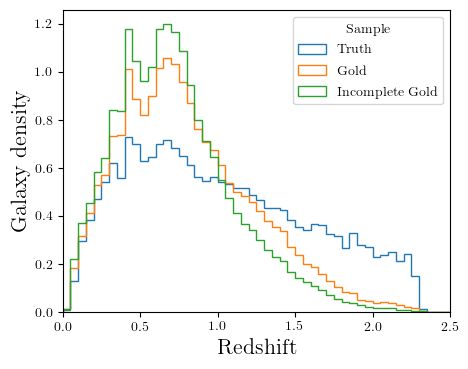

In [12]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": True,
    "histtype": "step",
}

ax.hist(samples_truth["redshift"], label="Truth", **hist_settings)
ax.hist(samples_gold_w_errs["redshift"], label="Gold", **hist_settings)
ax.hist(samples_incomplete_gold_w_errs["redshift"], label="Incomplete Gold", **hist_settings)
ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

You can see that the Gold sample has significantly fewer high-redshift galaxies than the truth. This is because many of the high-redshift galaxies have i > 25.3.

You can further see that the Incomplete Gold sample has even fewer high-redshift galaxies. This is exactly what we expected from this degrader.

<a id="LineConfusion"></a>
## Degrader 4: LineConfusion

`LineConfusion` is a degrader that simulates spectroscopic errors resulting from the confusion of different emission lines.

For this example, let's use the degrader to simulate a scenario in which which 2% of [OII] lines are mistaken as [OIII] lines, and 1% of [OIII] lines are mistaken as [OII] lines. (note I do not know how realistic this scenario is!)

In [13]:
def confusedIncompleteGoldWithErrs(data, seed=None):
    # apply error model, make cut on i band, introduce incompleteness
    data = incompleteGoldWithErrs(data, seed)
    
    # Oxygen lines (in angstroms)
    OII = 3727
    OIII = 5007
    # 2% OII -> OIII confusion
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)(data, seed)
    # 1% OIII -> OII confusion
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)(data, seed)
    
    return data

In [14]:
creator_conf_inc_gold_w_errs = Creator(flowEngine, degrader=confusedIncompleteGoldWithErrs)
samples_conf_inc_gold_w_errs = creator_conf_inc_gold_w_errs.sample(nsamples, seed=0)

Let's plot the redshift distributions one more time

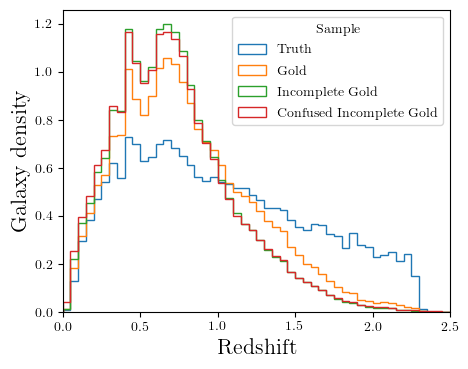

In [15]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": True,
    "histtype": "step",
}

ax.hist(samples_truth["redshift"], label="Truth", **hist_settings)
ax.hist(samples_gold_w_errs["redshift"], label="Gold", **hist_settings)
ax.hist(samples_incomplete_gold_w_errs["redshift"], label="Incomplete Gold", **hist_settings)
ax.hist(samples_conf_inc_gold_w_errs["redshift"], label="Confused Incomplete Gold", **hist_settings)
ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

You can see that the redshift distribution of this new sample is essentially identical to the Incomplete Gold sample, with small perturbations that result from the line confusion. 

However the real impact of this degrader isn't on the redshift distribution, but rather that it introduces erroneous spec-z's into the photo-z training sets! To see the impact of this effect, let's plot the true spec-z's as present in the Incomplete Gold sample, vs the spec-z's listed in the new sample with Oxygen Line Confusion.

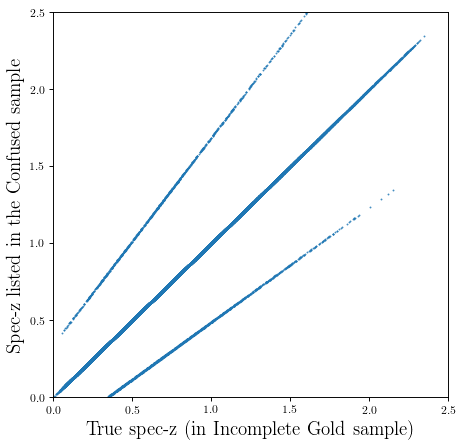

In [16]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=85)

ax.scatter(samples_incomplete_gold_w_errs["redshift"], samples_conf_inc_gold_w_errs["redshift"], 
           marker=".", s=1)

ax.set(
    xlim=(0, 2.5), ylim=(0, 2.5),
    xlabel="True spec-z (in Incomplete Gold sample)",
    ylabel="Spec-z listed in the Confused sample",
)
plt.show()

Now we can clearly see the spec-z errors! The galaxies above the line y=x are the [OII] -> [OIII] galaxies, while the ones below are the [OIII] -> [OII] galaxies.